In [ ]:
'''
Este notebook de Python implementa y entrena una Red Neuronal Convolucional (CNN) para la clasificación de imágenes. 
El objetivo es distinguir entre imágenes de caballos y humanos utilizando el conjunto de datos horses_or_humans de TensorFlow.

El flujo de trabajo se divide en los siguientes pasos clave:

    1. Carga y Preparación de Datos: Se descarga el dataset y se divide en conjuntos de entrenamiento (85%) y prueba (15%). 
    Las imágenes se preprocesan para ser redimensionadas y normalizadas, optimizando el rendimiento del modelo.

    2. Definición del Modelo CNN: Se construye una red neuronal secuencial con capas convolucionales y de agrupación (pooling) para extraer 
    características de las imágenes, seguidas por capas densas para la clasificación final. La salida usa una capa densa con activación sigmoid 
    para la predicción binaria.

    3. Entrenamiento y Evaluación: El modelo se compila con el optimizador adam y se entrena durante 10 épocas, midiendo su precisión en los datos 
    de entrenamiento y validación. Finalmente, se evalúa el rendimiento del modelo en el conjunto de prueba.

    4. Visualización de Resultados: Se generan gráficos que muestran la precisión del modelo a lo largo de las épocas, lo que ayuda a entender su 
    proceso de aprendizaje. Además, se visualizan las predicciones del modelo en algunas imágenes del conjunto de prueba, indicando si la predicción 
    es correcta (verde) o incorrecta (rojo).

    5. Predicción con una Imagen Local: La parte final del notebook permite probar el modelo con una imagen local (por ejemplo, persona.jpg), 
    mostrando la predicción del modelo y el nivel de confianza asociado.
'''

In [5]:
# https://www.tensorflow.org/datasets/catalog/horses_or_humans?hl=es

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os
import logging
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

In [6]:
# Desactivar logs innecesarios
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tfds.disable_progress_bar()
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [7]:
# 1. Cargar el dataset (dividir manualmente en train y test)
# 1. Cargar el dataset
(ds_train, ds_test), ds_info = tfds.load(
    'horses_or_humans',
    split=['train[:85%]', 'train[85%:]'],
    as_supervised=True,
    with_info=True
)

In [8]:
# 2. Preprocesamiento
def preprocess(image, label):
    image = tf.image.resize(image, [128, 128])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32

ds_train = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

ds_test = ds_test.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [9]:
# 3. Definir modelo CNN
# 3. Definir el modelo CNN
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Salida binaria
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

C:\Users\6003376\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# 4. Entrenamiento
history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=10
)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 281ms/step - accuracy: 0.6033 - loss: 0.7247 - val_accuracy: 0.9091 - val_loss: 0.2339
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - accuracy: 0.9614 - loss: 0.1217 - val_accuracy: 0.9545 - val_loss: 0.1169
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 263ms/step - accuracy: 0.9813 - loss: 0.0502 - val_accuracy: 0.9805 - val_loss: 0.0408
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - accuracy: 0.9863 - loss: 0.0389 - val_accuracy: 0.9740 - val_loss: 0.0544
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 254ms/step - accuracy: 0.9870 - loss: 0.0353 - val_accuracy: 0.9740 - val_loss: 0.0751
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 276ms/step - accuracy: 0.9895 - loss: 0.0232 - val_accuracy: 0.9935 - val_loss: 0.0274
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 258ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.9935 - val_loss: 0.0447
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 244ms/step - accuracy: 0.9915 - loss: 0.0230 - val_accuracy: 0

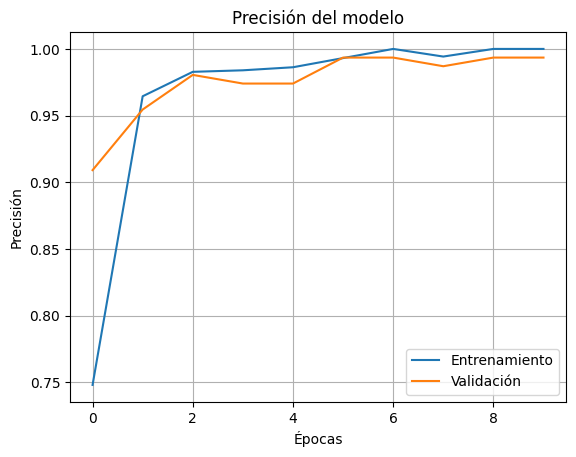

In [11]:
# 6. Graficar precisión
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión del modelo')
plt.legend()
plt.grid(True)
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9870 - loss: 0.0264

Test Accuracy: 99.35%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


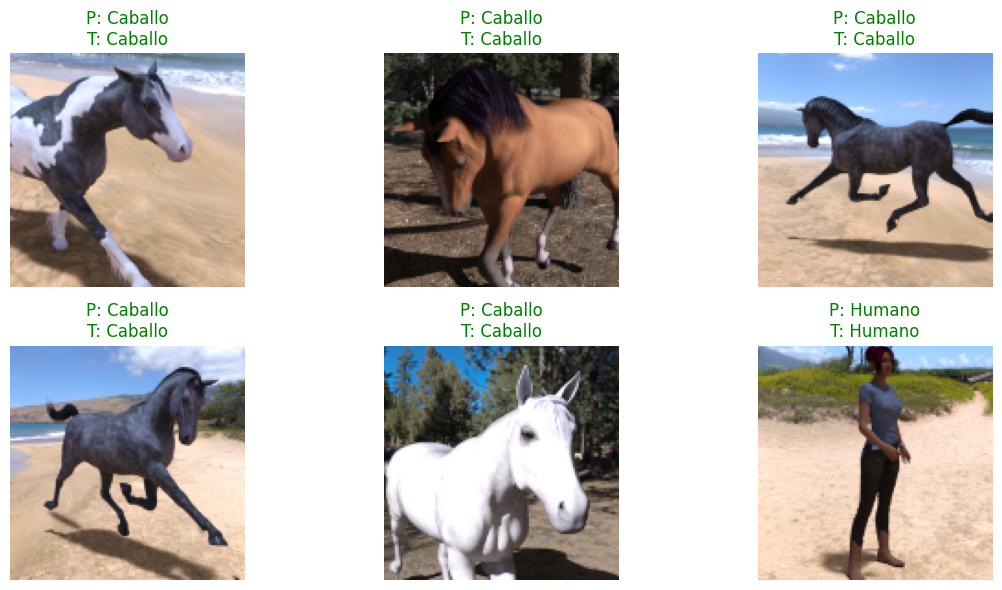

In [12]:
# 5. Evaluación
loss, acc = model.evaluate(ds_test)
print(f"\nTest Accuracy: {acc*100:.2f}%")

# 6. Visualización de predicciones
# 6. Visualización de predicciones
class_names = ['Caballo', 'Humano']
for images, labels in ds_test.take(1):
    preds = model.predict(images)
    plt.figure(figsize=(12, 6))
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])
        pred_label = 1 if preds[i] > 0.5 else 0
        true_label = labels[i].numpy()
        pred_text = class_names[pred_label]
        true_text = class_names[true_label]
        color = 'green' if pred_label == true_label else 'red'
        plt.title(f"P: {pred_text}\nT: {true_text}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    break


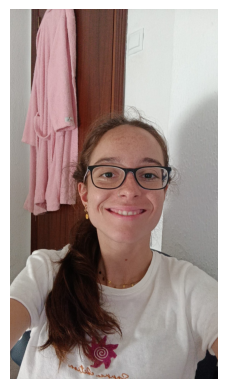

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Predicción: HUMANO (100.00% de confianza)


In [19]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import load_img, img_to_array

# Ruta a tu imagen local
img_path = r'C:\Users\6003376\Desktop\Marta\practicas\curso pandas y numpty\persona.jpg'
img_path2 = r'C:\Users\6003376\Desktop\Marta\practicas\curso pandas y numpty\selfie.jpeg'
img_path3 = r'C:\Users\6003376\Desktop\Marta\practicas\curso pandas y numpty\marta.jpeg'

plt.imshow(load_img(img_path3))
plt.axis('off')
plt.show()

# Cargar imagen
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalizar
img_array = np.expand_dims(img_array, axis=0)  # (1, 128, 128, 3)

pred = model.predict(img_array)[0][0]

# Mostrar predicción
if pred < 0.5:
    print(f"Predicción: CABALLO ({1 - pred:.2%} de confianza)")
else:
    print(f"Predicción: HUMANO ({pred:.2%} de confianza)")